In [1]:

# +
import torch
import torch.nn.functional as F
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import math
import warnings
from pathlib import Path
from tqdm.notebook import tqdm # Use notebook version of tqdm
from typing import Tuple, Any, Optional, List, Dict


Using device: cuda

--- Evaluating Model: te_polarbert_100M_2ep_250414-011046 ---
Loading config for checkpoint: last.ckpt...
Loading config associated with last.ckpt from config.yaml
Loading configuration from: /groups/pheno/inar/PolarBERT/checkpoints/te_polarbert_100M_2ep_250414-011046/config.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
Initializing model architecture...
  Using masking_prob from loaded config: 0.25
INFO: Concatenated embeddings directly match model embedding dim. No projection layer used.
Loading state dict from: last.ckpt...
  Loading state_dict from PyTorch Lightning checkpoint.
Model weights loaded.

Evaluating on Kaggle validation set...
Validating configuration...
Configuration validation passed (with potential warnings).
Creating kaggle evaluation dataloader...
  Source Dir: /groups/pheno/inar/icecube_kaggle/memmaped_eval_1M_127
  Num Events: 100000
  Batch Size: 512
Dataloader for kaggle created.


Evaluating DOM Loss:   0%|          | 0/100000 [00:00<?, ?it/s]

Kaggle Evaluation Complete. Collected 96138 loss values.
  Mean Loss: 1.7575, Median Loss: 1.6577

Evaluating on Prometheus validation set...
Validating configuration...
Configuration validation passed (with potential warnings).
Creating prometheus evaluation dataloader...
  Source Dir: /groups/pheno/inar/prometheus_data_updated/memmaped_pulses
  Num Events: 100000
  Batch Size: 512
Dataloader for prometheus created.


/tmp/ipykernel_1478974/1157266847.py:262: UserWarning: Processed only 99328 events out of requested 100000.
  warnings.warn(f"Processed only {processed_count} events out of requested {num_events_to_process}.")
/tmp/ipykernel_1478974/1157266847.py:267: UserWarning: Removed 3190 NaN loss values.
  warnings.warn(f"Removed {len(all_event_losses) - len(final_losses)} NaN loss values.")


Evaluating DOM Loss:   0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_1478974/1157266847.py:262: UserWarning: Processed only 99840 events out of requested 100000.
  warnings.warn(f"Processed only {processed_count} events out of requested {num_events_to_process}.")
/tmp/ipykernel_1478974/1157266847.py:267: UserWarning: Removed 7629 NaN loss values.
  warnings.warn(f"Removed {len(all_event_losses) - len(final_losses)} NaN loss values.")


Prometheus Evaluation Complete. Collected 92211 loss values.
  Mean Loss: 3.9860, Median Loss: 3.4300

--- Evaluating Model: te_polarbert_100M_1ep_big_250502-174201 ---
Loading config for checkpoint: last.ckpt...
Loading config associated with last.ckpt from config.yaml
Loading configuration from: /groups/pheno/inar/PolarBERT/checkpoints/te_polarbert_100M_1ep_big_250502-174201/config.yaml
Validating configuration...
Configuration validation passed (with potential warnings).
Initializing model architecture...
  Using masking_prob from loaded config: 0.25
INFO: Concatenated embeddings directly match model embedding dim. No projection layer used.
Loading state dict from: last.ckpt...
  Loading state_dict from PyTorch Lightning checkpoint.
Model weights loaded.

Evaluating on Kaggle validation set...
Validating configuration...
Configuration validation passed (with potential warnings).
Creating kaggle evaluation dataloader...
  Source Dir: /groups/pheno/inar/icecube_kaggle/memmaped_eval_1M

Evaluating DOM Loss:   0%|          | 0/100000 [00:00<?, ?it/s]

Kaggle Evaluation Complete. Collected 96582 loss values.
  Mean Loss: 1.7324, Median Loss: 1.6373

Evaluating on Prometheus validation set...
Validating configuration...
Configuration validation passed (with potential warnings).
Creating prometheus evaluation dataloader...
  Source Dir: /groups/pheno/inar/prometheus_data_updated/memmaped_pulses
  Num Events: 100000
  Batch Size: 512
Dataloader for prometheus created.


/tmp/ipykernel_1478974/1157266847.py:267: UserWarning: Removed 3258 NaN loss values.
  warnings.warn(f"Removed {len(all_event_losses) - len(final_losses)} NaN loss values.")


Evaluating DOM Loss:   0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_1478974/1157266847.py:267: UserWarning: Removed 7845 NaN loss values.
  warnings.warn(f"Removed {len(all_event_losses) - len(final_losses)} NaN loss values.")


Prometheus Evaluation Complete. Collected 91995 loss values.
  Mean Loss: 4.0395, Median Loss: 3.4391
Using plot range: (0, 10)


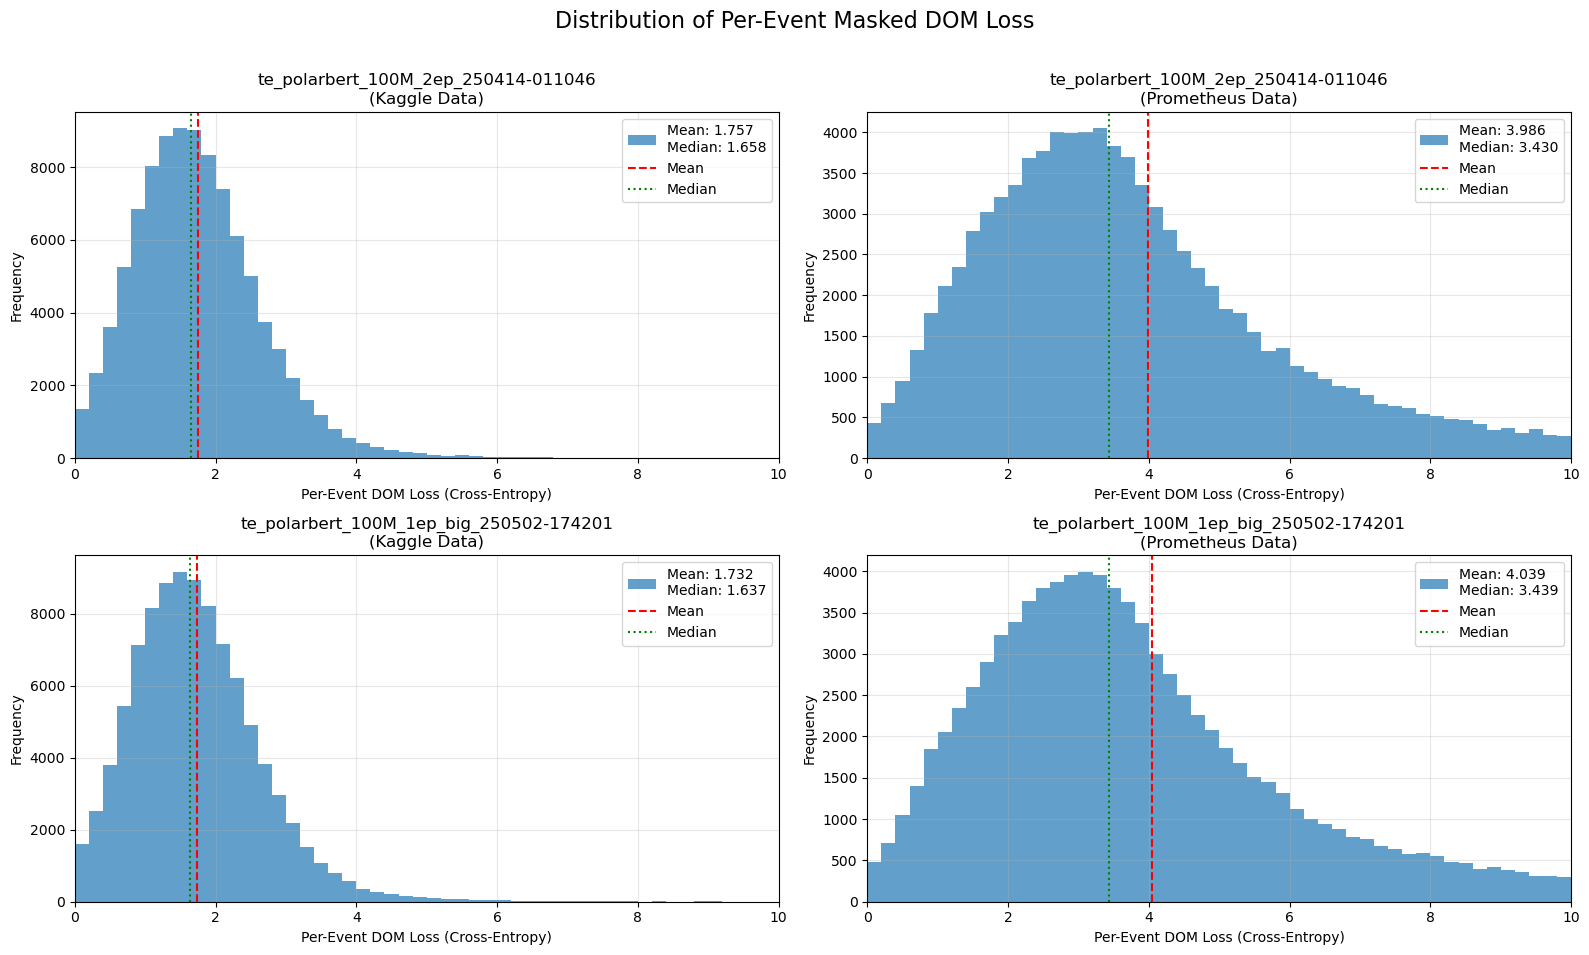

In [3]:

# --- Project Imports ---
# Ensure the 'src' directory is in the Python path or the package is installed
try:
    from polarbert.config import PolarBertConfig
    from polarbert.time_embed_polarbert import PolarBertModel # The model class used for pre-training
    from polarbert.dataloader_utils import (
        get_dataloaders,
        target_transform_prometheus,
        target_transform_kaggle,
        default_transform,
        default_target_transform
    )
    # Datasets are implicitly imported via get_dataloaders
except ImportError as e:
    print(f"Error importing project modules: {e}")
    print("Please ensure 'polarbert' is installed (`pip install -e .` from the project root)")
    print("or the 'src' directory is added to your PYTHONPATH.")
    # Add src to path if running script directly from notebook directory
    import sys
    sys.path.append(str(Path.cwd().parent)) # Assumes notebook is in 'notebooks' dir
    try:
        from polarbert.config import PolarBertConfig
        from polarbert.time_embed_polarbert import PolarBertModel
        from polarbert.dataloader_utils import (
             get_dataloaders, target_transform_prometheus, target_transform_kaggle,
             default_transform, default_target_transform
        )
        print("Added parent directory to path and re-imported successfully.")
    except ImportError:
         print("Failed to import project modules even after adding parent directory.")
         raise e

# %matplotlib inline
# -

# --- Constants and Paths ---
# Adjust these paths as necessary
CHECKPOINT_PATHS = [
    Path('/groups/pheno/inar/PolarBERT/checkpoints/te_polarbert_100M_2ep_250414-011046/last.ckpt'),
    Path('/groups/pheno/inar/PolarBERT/checkpoints/te_polarbert_100M_1ep_big_250502-174201/last.ckpt')
]

KAGGLE_VAL_DIR = '/groups/pheno/inar/icecube_kaggle/memmaped_eval_1M_127'
PROMETHEUS_VAL_DIR = '/groups/pheno/inar/prometheus_data_updated/memmaped_pulses' # Using the base dir specified in mixed_finetuning_config

NUM_EVENTS_EVAL = 100000
EVAL_BATCH_SIZE = 512 # Adjust based on GPU memory
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
for p in CHECKPOINT_PATHS:
    if not p.exists():
        warnings.warn(f"Checkpoint not found: {p}")
if not Path(KAGGLE_VAL_DIR).exists():
     warnings.warn(f"Kaggle validation directory not found: {KAGGLE_VAL_DIR}")
if not Path(PROMETHEUS_VAL_DIR).exists():
     warnings.warn(f"Prometheus validation directory not found: {PROMETHEUS_VAL_DIR}")

# ## 2. Helper Functions
def load_model_from_checkpoint(checkpoint_path: Path, device: torch.device) -> Tuple[PolarBertModel, PolarBertConfig]:
    """Loads the PolarBertModel and its config from a checkpoint."""
    if not checkpoint_path.exists():
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    print(f"Loading config for checkpoint: {checkpoint_path.name}...")
    try:
        # Try loading config from the same directory
        config = PolarBertConfig.from_checkpoint(str(checkpoint_path))
    except FileNotFoundError:
        # Fallback if config.yaml/final_config.yaml isn't found directly with checkpoint
        config_path_yaml = checkpoint_path.parent / "config.yaml"
        config_path_final = checkpoint_path.parent / "final_config.yaml"
        if config_path_yaml.exists():
            config = PolarBertConfig.from_yaml(str(config_path_yaml))
        elif config_path_final.exists():
             config = PolarBertConfig.from_yaml(str(config_path_final))
        else:
            raise FileNotFoundError(f"Could not find config.yaml or final_config.yaml in {checkpoint_path.parent}")
    except Exception as e:
        print(f"Error loading config: {e}")
        raise

    print("Initializing model architecture...")
    # Ensure masking is enabled in the embedding layer for pre-training style evaluation
    # The config loaded should already have the correct masking_prob under model.embedding
    # The PolarBertModel init will use this config.
    # config.model.embedding.masking_prob = config.training.mask_prob # <--- REMOVE THIS LINE

    # Add a check/print statement to confirm the value being used:
    print(f"  Using masking_prob from loaded config: {config.model.embedding.masking_prob}")

    model = PolarBertModel(config) # Uses the config associated with the checkpoint

    print(f"Loading state dict from: {checkpoint_path.name}...")
    try:
        # Use weights_only=True for security unless optimizer state is needed (not here)
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=True)
        # state_dict = checkpoint.get('state_dict', checkpoint) # Handle both PL ckpt and raw state dict
        # --- Updated state_dict loading ---
        # Check if it's a PL checkpoint with 'state_dict' key
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
             state_dict = checkpoint['state_dict']
             print("  Loading state_dict from PyTorch Lightning checkpoint.")
        # Check if it's already just a state_dict
        elif isinstance(checkpoint, dict) and all(isinstance(v, torch.Tensor) for v in checkpoint.values()):
             state_dict = checkpoint
             print("  Loading state_dict directly.")
        else:
            raise TypeError(f"Unrecognized checkpoint format: {type(checkpoint)}. Expected dict (PL checkpoint or state_dict).")
        # ------------------------------------

        # Clean keys (remove potential prefixes like 'model.')
        cleaned_state_dict = {}
        prefixes_to_remove = ['model.'] # Add 'backbone.' if needed
        for k, v in state_dict.items():
            key_modified = False
            for prefix in prefixes_to_remove:
                if k.startswith(prefix):
                    cleaned_state_dict[k[len(prefix):]] = v
                    key_modified = True; break
            if not key_modified:
                 # Only keep keys relevant to the model, ignore optimizer etc.
                 if not k.startswith(('optimizer.', 'lr_scheduler', '_forward_module')):
                      cleaned_state_dict[k] = v

        missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)
        print("Model weights loaded.")
        # Filter internal PL keys like _forward_module.main_model._modules...
        filtered_missing = [k for k in missing_keys if not k.startswith('_')]
        filtered_unexpected = [k for k in unexpected_keys if not k.startswith('_')]
        if filtered_missing: print("  Warning: Missing keys:", filtered_missing)
        if filtered_unexpected: print("  Warning: Unexpected keys:", filtered_unexpected)

    except Exception as e:
        print(f"ERROR loading checkpoint state_dict: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback
        raise

    model.to(device)
    model.eval() # Set to evaluation mode
    return model, config

def calculate_per_event_dom_loss(dom_logits: torch.Tensor,
                                 true_dom_ids: torch.Tensor,
                                 output_mask: Optional[torch.Tensor],
                                 seq_padding_mask: torch.Tensor, # Mask excluding CLS token
                                 epsilon: float = 1e-8) -> np.ndarray:
    """
    Calculates the masked DOM prediction cross-entropy loss for each event in a batch.

    Args:
        dom_logits: Logits from the DOM head (B, L_orig, N_classes).
        true_dom_ids: True DOM IDs (B, L_orig), where 0=PAD, 1=DOM_0, ..., N+1=DOM_N.
        output_mask: Boolean mask (B, L_orig) indicating tokens selected for loss calculation during forward pass.
                     If None or self.training is False, this mask isn't used directly here,
                     we rely on the target IDs.
        seq_padding_mask: Boolean mask (B, L_orig) where True indicates a padded position.
        epsilon: Small value to avoid division by zero.

    Returns:
        np.ndarray: Array of per-event losses (shape B).
    """
    batch_size, seq_len, num_classes = dom_logits.shape
    dom_targets = true_dom_ids - 1 # Target IDs: -1=PAD, 0=DOM_0, ..., N=DOM_N

    # --- Determine the effective mask for loss calculation ---
    # For evaluation, we typically want to calculate loss on *all* valid (non-padded) tokens
    # that were originally masked during the forward pass (indicated by output_mask if masking was on).
    # If output_mask is None (e.g., masking=False during forward), we calculate loss on all valid tokens.

    if output_mask is not None:
        # Use the mask generated during forward pass (pre-training style eval)
         effective_mask = output_mask & ~seq_padding_mask # Consider only non-padded masked tokens
    else:
        # If no output_mask (e.g., inference without masking), evaluate on all non-padded tokens
        effective_mask = ~seq_padding_mask

    # Ensure masks have the correct shape
    if effective_mask.shape != dom_targets.shape:
         raise ValueError(f"Mask shape {effective_mask.shape} incompatible with target shape {dom_targets.shape}")

    # Calculate cross-entropy loss per token, without reduction
    # Logits need shape (B, N_classes, L_orig)
    loss_per_token = F.cross_entropy(
        dom_logits.permute(0, 2, 1),
        dom_targets,
        ignore_index=-1, # Ignore padding tokens (where target is -1)
        reduction='none' # Get loss for each token: (B, L_orig)
    )

    # Apply the effective mask: Zero out losses for tokens not part of the evaluation
    masked_loss_per_token = loss_per_token * effective_mask.float()

    # Sum loss per event
    summed_loss_per_event = masked_loss_per_token.sum(dim=1) # (B,)

    # Count number of tokens contributing to the loss per event
    num_masked_tokens_per_event = effective_mask.sum(dim=1).float() # (B,)

    # Calculate average loss per event (handle division by zero)
    avg_loss_per_event = summed_loss_per_event / (num_masked_tokens_per_event + epsilon)

    # Handle events where no tokens were masked/valid -> loss should be NaN or 0? Let's use NaN.
    avg_loss_per_event[num_masked_tokens_per_event == 0] = float('nan')

    return avg_loss_per_event.cpu().numpy()


@torch.no_grad() # Ensure no gradients are computed
def evaluate_dom_loss_for_model(
    model: PolarBertModel,
    dataloader: DataLoader,
    num_events_to_process: int,
    device: torch.device
) -> List[float]:
    """Runs evaluation loop and collects per-event DOM losses."""
    model.eval()
    all_event_losses = []
    processed_count = 0

    pbar = tqdm(total=num_events_to_process, desc="Evaluating DOM Loss")

    for batch in dataloader:
        # --- Unpack Batch ---
        # Expects ((x, l), y_data) format from get_dataloaders
        (x, l), y_data = batch
        current_batch_size = x.size(0)

        # --- Move to Device ---
        x, l = x.to(device), l.to(device)
        # y_data might be None or contain tensors, handle device transfer if needed
        # For DOM loss, we only need x.

        # --- Forward Pass ---
        # The model's forward pass should internally handle masking if self.masking is True
        dom_logits, charge_pred, output_mask, seq_padding_mask = model.forward(batch=((x,l), y_data))
        # Note: charge_pred is ignored here

        # --- Get True DOM IDs ---
        true_dom_ids = x[:, :, 3].long() # (B, L_orig)

        # --- Calculate Per-Event Loss ---
        event_losses_batch = calculate_per_event_dom_loss(
            dom_logits,
            true_dom_ids,
            output_mask, # Pass the mask generated by the forward pass
            seq_padding_mask
        )

        # --- Store Results ---
        num_to_add = min(current_batch_size, num_events_to_process - processed_count)
        all_event_losses.extend(event_losses_batch[:num_to_add])
        processed_count += num_to_add
        pbar.update(num_to_add)

        if processed_count >= num_events_to_process:
            break

    pbar.close()
    if processed_count < num_events_to_process:
        warnings.warn(f"Processed only {processed_count} events out of requested {num_events_to_process}.")

    # Filter out potential NaNs before returning
    final_losses = [loss for loss in all_event_losses if not np.isnan(loss)]
    if len(final_losses) != len(all_event_losses):
        warnings.warn(f"Removed {len(all_event_losses) - len(final_losses)} NaN loss values.")

    return final_losses


# +
# Temporary DataConfig class simulation (adapt if DataConfig class is available)
class TempDataConfig:
    def __init__(self):
        self.train_dir = None # Not needed for validation
        self.val_dir = KAGGLE_VAL_DIR
        self.prometheus_dir = PROMETHEUS_VAL_DIR
        self.train_events = None # Not needed
        self.val_events = NUM_EVENTS_EVAL # Use this for Kaggle validation
        self.prometheus_train_events = None # Not needed
        self.prometheus_val_events = NUM_EVENTS_EVAL # Use this for Prometheus validation
        self.max_per_device_batch_size = EVAL_BATCH_SIZE
        self.pin_memory = True
        self.num_workers = 1
        self.persistent_workers = True

    def to_dict(self): # Add method if needed by downstream funcs
        return self.__dict__

def create_evaluation_dataloader(config: PolarBertConfig, dataset_type: str) -> DataLoader:
    """Creates a dataloader specifically for evaluation."""

    # Create a temporary config object to pass to get_dataloaders
    # This isolates evaluation settings from potential training config values
    eval_data_cfg = TempDataConfig() # Use the temporary class

    # --- Critical: Update the config object with eval settings ---
    # We modify a *copy* or use a temporary structure to avoid altering the original model config
    temp_config_dict = config.to_dict() # Get a dictionary representation

    # Override data paths and event counts for evaluation
    temp_config_dict['data']['val_dir'] = KAGGLE_VAL_DIR
    temp_config_dict['data']['prometheus_dir'] = PROMETHEUS_VAL_DIR
    temp_config_dict['data']['val_events'] = NUM_EVENTS_EVAL
    temp_config_dict['data']['prometheus_val_events'] = NUM_EVENTS_EVAL
    temp_config_dict['data']['max_per_device_batch_size'] = EVAL_BATCH_SIZE
    temp_config_dict['data']['num_workers'] = 1 # Often safer for IterableDataset eval
    temp_config_dict['data']['persistent_workers'] = True if temp_config_dict['data']['num_workers'] > 0 else False

    # Re-create a config object from the modified dict *if* get_dataloaders requires the object type
    # Otherwise, just pass the dictionary if get_dataloaders accepts it
    temp_eval_config = PolarBertConfig(
         data_cfg=temp_config_dict['data'],
         model_cfg=temp_config_dict['model'],
         training_cfg=temp_config_dict['training']
     )

    print(f"Creating {dataset_type} evaluation dataloader...")
    print(f"  Source Dir: {KAGGLE_VAL_DIR if dataset_type == 'kaggle' else PROMETHEUS_VAL_DIR}")
    print(f"  Num Events: {NUM_EVENTS_EVAL}")
    print(f"  Batch Size: {EVAL_BATCH_SIZE}")

    # Use the imported get_dataloaders function
    # It returns (train_loader, val_loader). We only need val_loader here.
    _, val_loader = get_dataloaders(
        config=temp_eval_config, # Pass the temporary config with eval settings
        dataset_type=dataset_type,
        transform=default_transform, # Basic transform is likely fine
        # Target transform might not be needed if only evaluating DOM loss
        # target_transform=(target_transform_kaggle if dataset_type == 'kaggle' else target_transform_prometheus),
        target_transform = default_target_transform, # Simpler transform if targets aren't used
        override_batch_size=EVAL_BATCH_SIZE # Explicitly set batch size for evaluation
    )
    print(f"Dataloader for {dataset_type} created.")
    return val_loader
# -

# ## 3. Evaluation Loop

# +
evaluation_results = {} # Dictionary to store losses: {model_name: {dataset_type: [losses]}}

for ckpt_path in CHECKPOINT_PATHS:
    model_name = ckpt_path.parent.name # Use directory name as model identifier
    print(f"\n--- Evaluating Model: {model_name} ---")
    evaluation_results[model_name] = {}

    try:
        model, config = load_model_from_checkpoint(ckpt_path, DEVICE)

        # --- Evaluate on Kaggle ---
        print(f"\nEvaluating on Kaggle validation set...")
        kaggle_loader = create_evaluation_dataloader(config, 'kaggle')
        kaggle_losses = evaluate_dom_loss_for_model(model, kaggle_loader, NUM_EVENTS_EVAL, DEVICE)
        evaluation_results[model_name]['kaggle'] = kaggle_losses
        print(f"Kaggle Evaluation Complete. Collected {len(kaggle_losses)} loss values.")
        if kaggle_losses:
             print(f"  Mean Loss: {np.mean(kaggle_losses):.4f}, Median Loss: {np.median(kaggle_losses):.4f}")
        del kaggle_loader # Free memory

        # --- Evaluate on Prometheus ---
        print(f"\nEvaluating on Prometheus validation set...")
        # Prometheus loader needs the prometheus_dir set correctly in the passed config
        # Ensure the 'prometheus_dir' is correctly set in the TempDataConfig used by create_evaluation_dataloader
        prometheus_loader = create_evaluation_dataloader(config, 'prometheus')
        prometheus_losses = evaluate_dom_loss_for_model(model, prometheus_loader, NUM_EVENTS_EVAL, DEVICE)
        evaluation_results[model_name]['prometheus'] = prometheus_losses
        print(f"Prometheus Evaluation Complete. Collected {len(prometheus_losses)} loss values.")
        if prometheus_losses:
            print(f"  Mean Loss: {np.mean(prometheus_losses):.4f}, Median Loss: {np.median(prometheus_losses):.4f}")
        del prometheus_loader # Free memory

        del model # Free GPU memory before loading next model
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()

    except FileNotFoundError as e:
        print(f"Skipping model {model_name} due to FileNotFoundError: {e}")
    except Exception as e:
        print(f"An error occurred while evaluating model {model_name}: {e}")
        # Optionally add more specific error handling or traceback printing
        import traceback
        traceback.print_exc()
# -

# ## 4. Plotting Results

# +
num_models = len(evaluation_results)
datasets = ['kaggle', 'prometheus']
num_datasets = len(datasets)

if num_models == 0:
    print("No evaluation results found to plot.")
else:
    fig, axes = plt.subplots(num_models, num_datasets, figsize=(8 * num_datasets, 5 * num_models), squeeze=False)
    fig.suptitle('Distribution of Per-Event Masked DOM Loss', fontsize=16)

    plot_range = None # Auto-range initially

    # --- Find common plot range (optional, helps comparison) ---
    all_losses = []
    for model_name, dataset_losses in evaluation_results.items():
        for dataset_type, losses in dataset_losses.items():
            if losses:
                all_losses.extend(losses)
    if all_losses:
        # Set range based on percentiles to avoid outliers dominating
        # plot_range = (np.percentile(all_losses, 1), np.percentile(all_losses, 99))
        # Or set a fixed range if preferred
        plot_range=(0, 10) # Example fixed range, adjust as needed
        print(f"Using plot range: {plot_range}")


    # --- Create Histograms ---
    for i, (model_name, dataset_losses) in enumerate(evaluation_results.items()):
        for j, dataset_type in enumerate(datasets):
            ax = axes[i, j]
            losses = dataset_losses.get(dataset_type)

            if losses:
                mean_loss = np.mean(losses)
                median_loss = np.median(losses)

                ax.hist(losses, bins=50, range=plot_range, alpha=0.7, label=f'Mean: {mean_loss:.3f}\nMedian: {median_loss:.3f}')
                ax.axvline(mean_loss, color='red', linestyle='--', linewidth=1.5, label=f'Mean')
                ax.axvline(median_loss, color='green', linestyle=':', linewidth=1.5, label=f'Median')
                ax.set_title(f"{model_name}\n({dataset_type.capitalize()} Data)")
                ax.set_xlabel("Per-Event DOM Loss (Cross-Entropy)")
                ax.set_ylabel("Frequency")
                ax.legend()
                ax.grid(True, alpha=0.3)
                # ax.set_yscale('log') # Optional: Use log scale if distribution is highly skewed
            else:
                ax.set_title(f"{model_name}\n({dataset_type.capitalize()} Data)")
                ax.text(0.5, 0.5, "No data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_xlim(left=plot_range[0] if plot_range else None, right=plot_range[1] if plot_range else None)


    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
    plt.show()
# -

# ## 5. Summary
#
# The histograms above show the distribution of the masked DOM prediction loss for each model on the Kaggle and Prometheus validation datasets.
#
# - **Lower loss** generally indicates better performance in reconstructing the original DOM IDs that were masked during the forward pass.
# - **Distribution shape:** A narrower peak closer to zero is desirable. Long tails indicate events where the model struggled significantly.
# - **Comparison:** Observe differences in mean/median loss and the overall shape of the distributions between models and datasets. This can highlight which model generalizes better or if there are significant differences in the difficulty of the datasets for this specific pre-training task.